In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3, batman
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

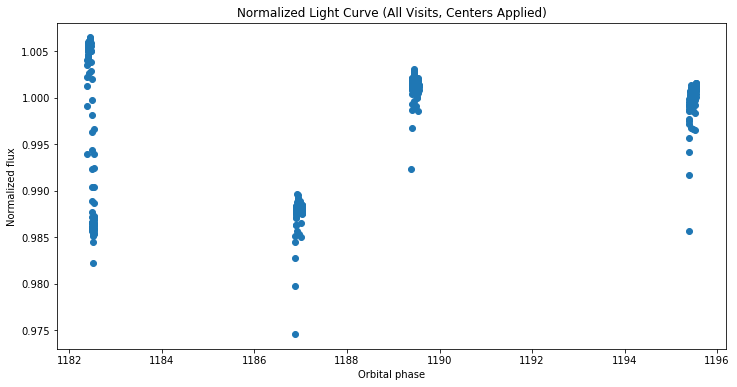

In [2]:
# Reading in the center applied lc data. Created in "centering.ipynb" notebook
data       = ascii.read('lc_info.csv')

# Obtaining Normalized fux
#Everett: Should I divide each visit by it's own median or is the next step fine?
norm_flux  = data['res_flux']/np.median(data['res_flux'])

# Calculating time and orbital phase
transit_cen = 2454159.45320
period      = 1.5089557
jd_const    = 2400000.5
time_jd     = data['time'] + jd_const
orbitalP    = np.sort((time_jd - transit_cen)/period)

#Plotting light curve
fig, ax = plt.subplots()
points = ax.plot(orbitalP, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Normalized Light Curve (All Visits, Centers Applied)')

# mpld3 stuff
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['Point {}'.format(i + 1) for i in range(len(orbitalP))]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
plugins.connect(fig, tooltip)

# Primary Transit

In [3]:
# Initializing batman model
params           = batman.TransitParams()
params.t0        = 2454159.45320     #time of inferior conjunction
params.per       = 1.5089557                #orbital period
params.rp        = 0.135                    #planet radius (in units of stellar radii)
params.a         = 4.901                    #semi-major axis (in units of stellar radii)
params.inc       = 85.10                    #orbital inclination (in degrees)
params.ecc       = 0.                       #eccentricity
params.w         = 90.                      #longitude of periastron (in degrees)
params.u         = [0.1, 0.3]               #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"              #limb darkening model

In [4]:
# Exponential model
def exp(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

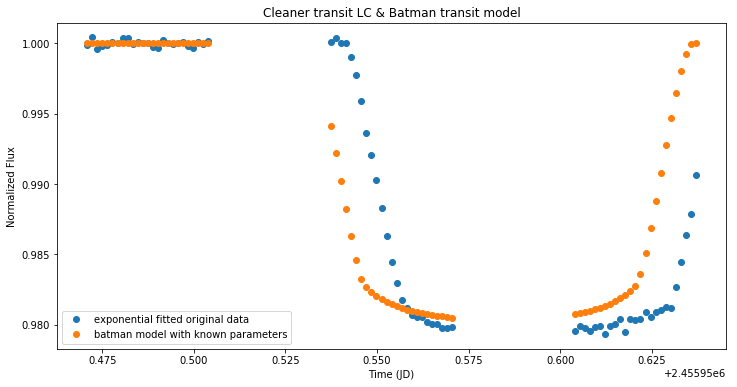

In [5]:
#Parmetrizing exponential model for 1st visit, 2nd orbit (12)
op12     = orbitalP[23:48]
flux12   = norm_flux[23:48]
param, _ = curve_fit(exp, op12-op12[0], flux12, p0=(1, (1.5*24*60)/10, 0))

f_v1o2 = norm_flux[23:48]/exp(orbitalP[23:48] - orbitalP[23], *param)
f_v1o3 = norm_flux[48:73]/exp(orbitalP[48:73] - orbitalP[48], *param)
f_v1o4 = norm_flux[73:98]/exp(orbitalP[73:98] - orbitalP[73], *param)

f_v1 = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
plt.plot(time_jd[23:98], f_v1, 'o', label = 'exponential fitted original data')


t = time_jd[23:98]
m = batman.TransitModel(params, t)    
flux = m.light_curve(params)
plt.plot(t, flux, 'o', label = 'batman model with known parameters')

plt.xlabel('Time (JD)')
plt.ylabel('Normalized Flux')
plt.title('Cleaner transit LC & Batman transit model')
plt.legend(loc = 'best')

In [6]:
mpld3.disable_notebook()

best fit rp: 0.132272272272


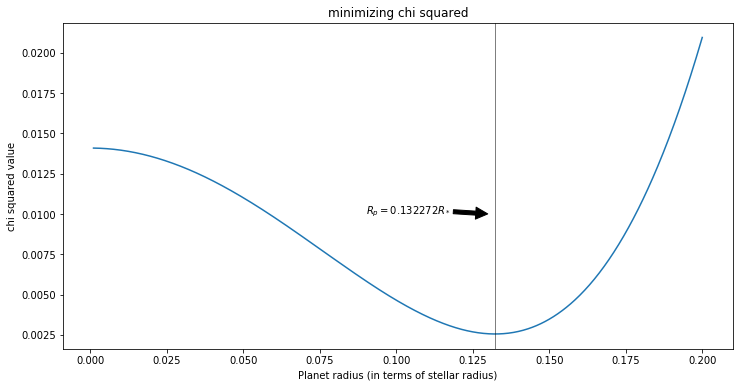

In [7]:
r_guess = np.linspace(0.001, 0.2, 1000)
cs_val  = np.array([])  #will hold the chi squared values

# calculating a chi_squared value for each r
for r in r_guess:
    params.rp = r
    m         = batman.TransitModel(params, t)    
    model     = m.light_curve(params)
    chi_sq    = np.sum((f_v1-model)**2/model)  #f_v1 is the original data divided by an exponential model
    cs_val    = np.append(cs_val, chi_sq)

# Visualizing chi_squared as a function of r
plt.plot(r_guess, cs_val)
plt.xlabel('Planet radius (in terms of stellar radius)')
plt.ylabel('chi squared value')
plt.title('minimizing chi squared')

# Finding the best r, the one corresponding to least chi_squared
ind = np.argmin(cs_val)
best_r = r_guess[ind]
plt.axvline(x=best_r, linewidth = 0.5, color = 'k')
plt.annotate(r'$R_p=%2f R_*$' % best_r , xy=(0.13, 0.01), xytext=(0.09, 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.01),)
print('best fit rp:', best_r)
plt.savefig('transit_depth.pdf')

#### Finding r for 10 different wavelength ranges

In [8]:
flux_array = np.load('ten_box_fluxes.npy') #created in "Batman & Exponential model.ipynb"
best_r     = np.array([]) #wil hold the best radius for each wavelength range

for i in range(10):
    cs_val = np.array([])
    
    # normalized fluxes
    #Everett: Can I use a single median for each visit instead of doing it in 3 steps?
    n_v1o2 = flux_array[23:48,i]/np.median(flux_array[23:98,i])
    n_v1o3 = flux_array[48:73,i]/np.median(flux_array[23:98,i])
    n_v1o4 = flux_array[73:98,i]/np.median(flux_array[23:98,i])
    
    #detrended fluxes
    f_v1o2 = n_v1o2/exp(orbitalP[23:48] - orbitalP[23], *param)
    f_v1o3 = n_v1o3/exp(orbitalP[48:73] - orbitalP[48], *param)
    f_v1o4 = n_v1o4/exp(orbitalP[73:98] - orbitalP[73], *param)
    
    data1 = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
    
    m = batman.TransitModel(params, t)
    for r in r_guess:
        params.rp = r    
        model = m.light_curve(params)
        chi_sq = np.sum((data1-model)**2/model)
        cs_val = np.append(cs_val, chi_sq)
    ind = np.argmin(cs_val)
    best_r = np.append(best_r, r_guess[ind])
best_r

array([ 0.11055956,  0.10717317,  0.10498198,  0.10677477,  0.10338839,
        0.11016116,  0.10518118,  0.09502202,  0.09840841,  0.1004004 ])

In [9]:
wavelength = np.load('wavelength.npy')
wl_bins = []
start = 0
width = 13  #128/10 = 12.8 ~ 13
for i in range(10):
    
    if (start + 13) < 128:
        stop = start + 13
    else:
        stop = 127  #when list is out of index, stop at the last point
    
    wl_bins.append(np.mean(wavelength[start:stop]))
    start += 13
wl_bins

[11030.468170587972,
 11637.077892376776,
 12243.687614165576,
 12850.297335954381,
 13456.907057743181,
 14063.516779531985,
 14670.126501320785,
 15276.736223109587,
 15883.345944898389,
 16419.962237250023]

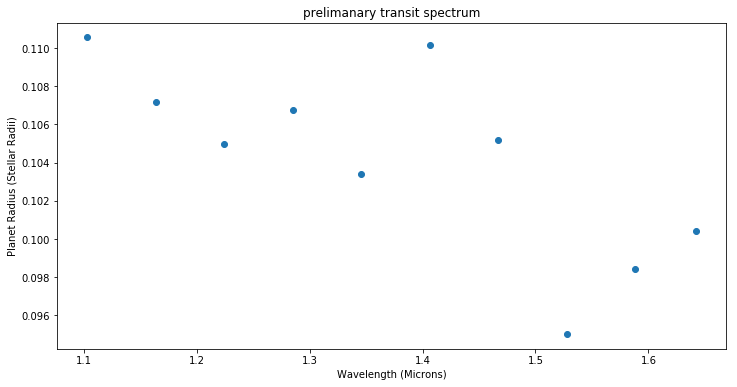

In [10]:
fig, ax = plt.subplots()
ax.plot(np.array(wl_bins)/1e4, best_r, 'o')
ax.set_title('prelimanary transit spectrum')
ax.set_ylabel('Planet Radius (Stellar Radii)')
ax.set_xlabel('Wavelength (Microns)')

plugins.connect(fig, plugins.MousePosition(fontsize=14))

# Secondary Eclipse 1

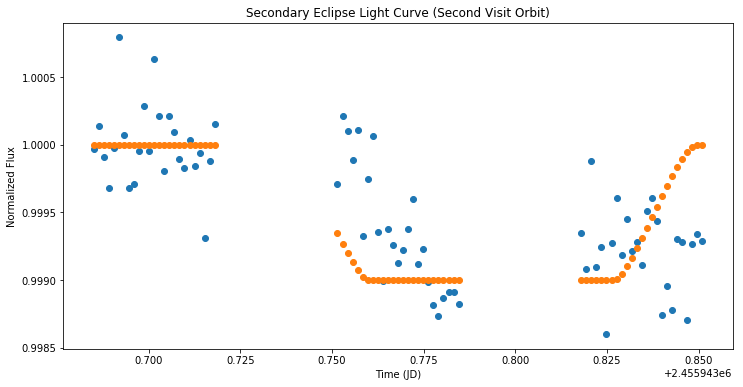

In [15]:
params.fp          = 0.001                       # Planet to star flux ratio
params.t_secondary = transit_cen + 0.75447785    # Central eclipse time (tc + op/2)

op22     = orbitalP[121:146]
flux22   = norm_flux[121:146]
param, _ = curve_fit(exp, op22-op22[0], flux22, p0=(1, (1.5*24*60)/10, 0))

f_v2o2 = norm_flux[121:146]/exp(orbitalP[121:146] - orbitalP[121], *param)
f_v2o3 = norm_flux[146:171]/exp(orbitalP[146:171] - orbitalP[146], *param)
f_v2o4 = norm_flux[171:196]/exp(orbitalP[171:196] - orbitalP[171], *param)

f_v2 = np.concatenate((f_v2o2,f_v2o3,f_v2o4))
plt.plot(time_jd[121:196], f_v2, 'o', label = 'exponential fitted original data')

t = time_jd[121:196]
m = batman.TransitModel(params, t, transittype="secondary")
flux = m.light_curve(params)
plt.plot(t, flux-0.001, 'o')
plt.xlabel('Time (JD)')
plt.ylabel('Normalized Flux')
plt.title('Secondary Eclipse Light Curve (Second Visit Orbit)')
plt.savefig('second_eclipse.pdf')
#flux-0.001 because I normalized the entire visit using second orbit, so second orbit is 1 but batman normalizes the dip. 
#Since the depth was 0.1%, I made an offset so we can see the data and model together

best fit fp: 0.0001


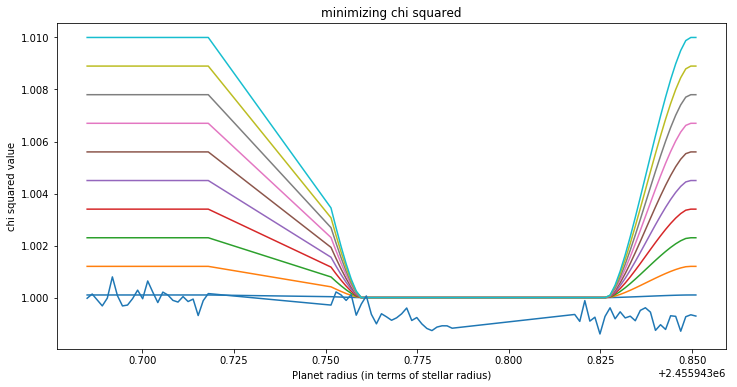

In [12]:
fp_guess = np.linspace(0.0001, 0.01, 10)
cs_val  = np.array([])  #will hold the chi squared values

# calculating a chi_squared value for each fp guess
for fp in fp_guess:
    params.fp = fp
    m         = batman.TransitModel(params, t, transittype="secondary")    
    model     = m.light_curve(params)
    chi_sq    = np.sum((f_v2-model)**2/model)  #f_v1 is the original data divided by an exponential model
    cs_val    = np.append(cs_val, chi_sq)
    plt.plot(t, model)

plt.plot(t, f_v2)

# Visualizing chi_squared as a function of flux ratio
# plt.plot(fp_guess, cs_val)
plt.xlabel('Planet radius (in terms of stellar radius)')
plt.ylabel('chi squared value')
plt.title('minimizing chi squared')

# Finding the best r, the one corresponding to least chi_squared
ind = np.argmin(cs_val)
best_fp = fp_guess[ind]
print('best fit fp:', best_fp)

#### Finding fp (flux ratio: flux of planet in units of stellar flux) for 10 different wavelength ranges

In [13]:
fp_guess   = np.linspace(0.0001, 0.01, 1000)
best_fp    = np.array([]) #wil hold the flux ratio that minimizes chi-squared for each wavelength range

for i in range(10):
    cs_val = np.array([])
    
    # normalized fluxes
    n_v2o2 = flux_array[121:146,i]/np.median(flux_array[121:146,i])
    n_v2o3 = flux_array[146:171,i]/np.median(flux_array[146:171,i])
    n_v2o4 = flux_array[171:196,i]/np.median(flux_array[171:196,i])
    
    #detrended fluxes
    f_v2o2 = n_v2o2/exp(orbitalP[121:146] - orbitalP[121], *param)
    f_v2o3 = n_v2o3/exp(orbitalP[146:171] - orbitalP[146], *param)
    f_v2o4 = n_v2o4/exp(orbitalP[171:196] - orbitalP[171], *param)
    
    data2 = np.concatenate((f_v2o2,f_v2o3,f_v2o4))
    
    m = batman.TransitModel(params, t, transittype="secondary")
    for fp in fp_guess:
        params.fp = fp    
        model = m.light_curve(params)
        chi_sq = np.sum((data2-model)**2/model)
        cs_val = np.append(cs_val, chi_sq)
    ind = np.argmin(cs_val)
    best_fp = np.append(best_fp, fp_guess[ind])
best_fp

array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01])